In [ ]:
# !pip install gensim --upgrade
# !pip install keras --upgrade
# !pip install pandas --upgrade

In [ ]:
# Regular Package

import io
import csv
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from string import *
import time
import pickle
import itertools

# nltk
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import *
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import *
from gensim import *
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

# sklearn
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# WordCloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict

# Word2vec
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

#matplolib
import matplotlib.pyplot as plt

# Tensorflow
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers

# Keras
!pip install keras
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
#from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
#from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = pd.read_csv("Twitter_Data.csv")
df1 = df

In [ ]:
df.head(5)

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [ ]:
df = df[df.category != 0.0]

In [ ]:
df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107767 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  107765 non-null  object 
 1   category    107760 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [ ]:
# Varaibles related to dataset
DATASET_COLUMNS = ["clean_text", "category"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# Parameters for WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# Parameters related to KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# Variable specific to SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# Variables for Exporting purpose
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

# MISC

plt.style.use('fivethirtyeight')
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250

In [ ]:
# Confirming presence of missing values in each variable
df.isnull().sum()


clean_text    2
category      7
dtype: int64

In [ ]:
df.dropna(how='any', inplace=True) # Removed these rows as the count is small and will not affect overall modelling
df.isnull().sum()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


clean_text    0
category      0
dtype: int64

In [ ]:
decode_map = {-1.0: "NEGATIVE", 1.0: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
df.category = df.category.apply(lambda x: decode_sentiment(x))

CPU times: user 84.1 ms, sys: 6.6 ms, total: 90.7 ms
Wall time: 113 ms


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Text(0.5, 1.0, 'Dataset labels distribuition')

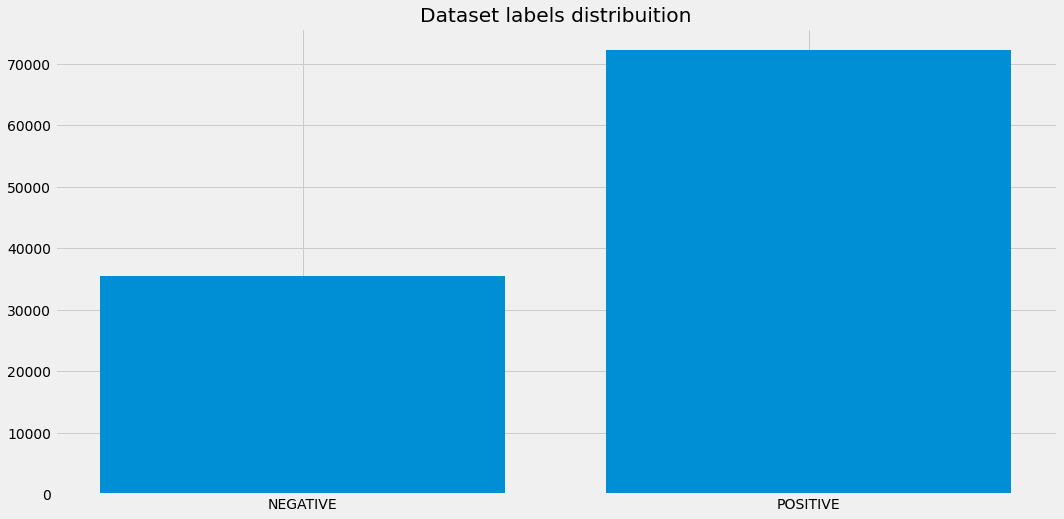

In [ ]:
category_cnt = Counter(df.category)

plt.figure(figsize=(16,8))
plt.bar(category_cnt.keys(), category_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
# Including Stopwords and exclusing 'not' related stopwords

stop_words = set(stopwords.words("english"))
stop_words.remove('not')
more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
stop_words = stop_words.union(more_stopwords)
                 
stemmer = SnowballStemmer("english")

In [ ]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'^[^ ]<.*?>|&([a-z0-9]+|#[0-9]\"\'\“{1,6}|#x[0-9a-f]{1,6});[^A-Za-z0-9]+')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def remove_quotes(text):
    quotes = re.compile(r'[^A-Za-z0-9\s]+')
    return re.sub(quotes, '', text)


# Applying helper functions

df['mod_text'] = df['clean_text'].apply(lambda x: remove_URL(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_emoji(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_html(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_punct(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_quotes(x))
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,clean_text,category,mod_text
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...
2,what did just say vote for modi welcome bjp t...,POSITIVE,what did just say vote for modi welcome bjp t...
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...
4,answer who among these the most powerful world...,POSITIVE,answer who among these the most powerful world...
8,with upcoming election india saga going import...,POSITIVE,with upcoming election india saga going import...


In [ ]:
# Tokenizing the tweet base texts.

df['tokenized'] = df['mod_text'].apply(word_tokenize)

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,clean_text,category,mod_text,tokenized
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...,"[when, modi, promised, minimum, government, ma..."
2,what did just say vote for modi welcome bjp t...,POSITIVE,what did just say vote for modi welcome bjp t...,"[what, did, just, say, vote, for, modi, welcom..."
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t..."
4,answer who among these the most powerful world...,POSITIVE,answer who among these the most powerful world...,"[answer, who, among, these, the, most, powerfu..."
8,with upcoming election india saga going import...,POSITIVE,with upcoming election india saga going import...,"[with, upcoming, election, india, saga, going,..."


In [ ]:
# Lower casing clean text.

df['lower'] = df['tokenized'].apply(lambda x: [word.lower() for word in x])

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,clean_text,category,mod_text,tokenized,lower
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...,"[when, modi, promised, minimum, government, ma...","[when, modi, promised, minimum, government, ma..."
2,what did just say vote for modi welcome bjp t...,POSITIVE,what did just say vote for modi welcome bjp t...,"[what, did, just, say, vote, for, modi, welcom...","[what, did, just, say, vote, for, modi, welcom..."
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t...","[asking, his, supporters, prefix, chowkidar, t..."
4,answer who among these the most powerful world...,POSITIVE,answer who among these the most powerful world...,"[answer, who, among, these, the, most, powerfu...","[answer, who, among, these, the, most, powerfu..."
8,with upcoming election india saga going import...,POSITIVE,with upcoming election india saga going import...,"[with, upcoming, election, india, saga, going,...","[with, upcoming, election, india, saga, going,..."


In [ ]:
# Removing stopwords.

df['stopwords_removed'] = df['lower'].apply(
    lambda x: [word for word in x if word not in stop_words])

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,clean_text,category,mod_text,tokenized,lower,stopwords_removed
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...,"[when, modi, promised, minimum, government, ma...","[when, modi, promised, minimum, government, ma...","[modi, promised, minimum, government, maximum,..."
2,what did just say vote for modi welcome bjp t...,POSITIVE,what did just say vote for modi welcome bjp t...,"[what, did, just, say, vote, for, modi, welcom...","[what, did, just, say, vote, for, modi, welcom...","[say, vote, modi, welcome, bjp, told, rahul, m..."
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t...","[asking, his, supporters, prefix, chowkidar, t...","[asking, supporters, prefix, chowkidar, names,..."
4,answer who among these the most powerful world...,POSITIVE,answer who among these the most powerful world...,"[answer, who, among, these, the, most, powerfu...","[answer, who, among, these, the, most, powerfu...","[answer, among, powerful, world, leader, today..."
8,with upcoming election india saga going import...,POSITIVE,with upcoming election india saga going import...,"[with, upcoming, election, india, saga, going,...","[with, upcoming, election, india, saga, going,...","[upcoming, election, india, saga, going, impor..."


In [ ]:
# Applying part of speech tags.

df['pos_tags'] = df['stopwords_removed'].apply(nltk.tag.pos_tag)

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,clean_text,category,mod_text,tokenized,lower,stopwords_removed,pos_tags
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...,"[when, modi, promised, minimum, government, ma...","[when, modi, promised, minimum, government, ma...","[modi, promised, minimum, government, maximum,...","[(modi, NNS), (promised, VBD), (minimum, JJ), ..."
2,what did just say vote for modi welcome bjp t...,POSITIVE,what did just say vote for modi welcome bjp t...,"[what, did, just, say, vote, for, modi, welcom...","[what, did, just, say, vote, for, modi, welcom...","[say, vote, modi, welcome, bjp, told, rahul, m...","[(say, VB), (vote, NN), (modi, FW), (welcome, ..."
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t...","[asking, his, supporters, prefix, chowkidar, t...","[asking, supporters, prefix, chowkidar, names,...","[(asking, VBG), (supporters, NNS), (prefix, VB..."
4,answer who among these the most powerful world...,POSITIVE,answer who among these the most powerful world...,"[answer, who, among, these, the, most, powerfu...","[answer, who, among, these, the, most, powerfu...","[answer, among, powerful, world, leader, today...","[(answer, NN), (among, IN), (powerful, JJ), (w..."
8,with upcoming election india saga going import...,POSITIVE,with upcoming election india saga going import...,"[with, upcoming, election, india, saga, going,...","[with, upcoming, election, india, saga, going,...","[upcoming, election, india, saga, going, impor...","[(upcoming, JJ), (election, NN), (india, NN), ..."


In [ ]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


df['wordnet_pos'] = df['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,clean_text,category,mod_text,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...,"[when, modi, promised, minimum, government, ma...","[when, modi, promised, minimum, government, ma...","[modi, promised, minimum, government, maximum,...","[(modi, NNS), (promised, VBD), (minimum, JJ), ...","[(modi, n), (promised, v), (minimum, a), (gove..."
2,what did just say vote for modi welcome bjp t...,POSITIVE,what did just say vote for modi welcome bjp t...,"[what, did, just, say, vote, for, modi, welcom...","[what, did, just, say, vote, for, modi, welcom...","[say, vote, modi, welcome, bjp, told, rahul, m...","[(say, VB), (vote, NN), (modi, FW), (welcome, ...","[(say, v), (vote, n), (modi, n), (welcome, a),..."
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t...","[asking, his, supporters, prefix, chowkidar, t...","[asking, supporters, prefix, chowkidar, names,...","[(asking, VBG), (supporters, NNS), (prefix, VB...","[(asking, v), (supporters, n), (prefix, v), (c..."
4,answer who among these the most powerful world...,POSITIVE,answer who among these the most powerful world...,"[answer, who, among, these, the, most, powerfu...","[answer, who, among, these, the, most, powerfu...","[answer, among, powerful, world, leader, today...","[(answer, NN), (among, IN), (powerful, JJ), (w...","[(answer, n), (among, n), (powerful, a), (worl..."
8,with upcoming election india saga going import...,POSITIVE,with upcoming election india saga going import...,"[with, upcoming, election, india, saga, going,...","[with, upcoming, election, india, saga, going,...","[upcoming, election, india, saga, going, impor...","[(upcoming, JJ), (election, NN), (india, NN), ...","[(upcoming, a), (election, n), (india, n), (sa..."


In [ ]:
# Applying word lemmatizer.

wnl = WordNetLemmatizer()

df['lemmatized'] = df['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

df['lemmatized'] = df['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop_words])

df['lemma_str'] = [' '.join(map(str, l)) for l in df['lemmatized']]

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

,clean_text,category,mod_text,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...,"[when, modi, promised, minimum, government, ma...","[when, modi, promised, minimum, government, ma...","[modi, promised, minimum, government, maximum,...","[(modi, NNS), (promised, VBD), (minimum, JJ), ...","[(modi, n), (promised, v), (minimum, a), (gove...","[modi, promise, minimum, government, maximum, ...",modi promise minimum government maximum govern...
2,what did just say vote for modi welcome bjp t...,POSITIVE,what did just say vote for modi welcome bjp t...,"[what, did, just, say, vote, for, modi, welcom...","[what, did, just, say, vote, for, modi, welcom...","[say, vote, modi, welcome, bjp, told, rahul, m...","[(say, VB), (vote, NN), (modi, FW), (welcome, ...","[(say, v), (vote, n), (modi, n), (welcome, a),...","[say, vote, modi, welcome, bjp, tell, rahul, m...",say vote modi welcome bjp tell rahul main camp...
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t...","[asking, his, supporters, prefix, chowkidar, t...","[asking, supporters, prefix, chowkidar, names,...","[(asking, VBG), (supporters, NNS), (prefix, VB...","[(asking, v), (supporters, n), (prefix, v), (c...","[ask, supporter, prefix, chowkidar, name, modi...",ask supporter prefix chowkidar name modi great...
4,answer who among these the most powerful world...,POSITIVE,answer who among these the most powerful world...,"[answer, who, among, these, the, most, powerfu...","[answer, who, among, these, the, most, powerfu...","[answer, among, powerful, world, leader, today...","[(answer, NN), (among, IN), (powerful, JJ), (w...","[(answer, n), (among, n), (powerful, a), (worl...","[answer, among, powerful, world, leader, today...",answer among powerful world leader today trump...
8,with upcoming election india saga going import...,POSITIVE,with upcoming election india saga going import...,"[with, upcoming, election, india, saga, going,...","[with, upcoming, election, india, saga, going,...","[upcoming, election, india, saga, going, impor...","[(upcoming, JJ), (election, NN), (india, NN), ...","[(upcoming, a), (election, n), (india, n), (sa...","[upcoming, election, india, saga, go, importan...",upcoming election india saga go important pair...


In [ ]:
print("Total Rows =", len(df.clean_text))

Total Rows = 107758


In [ ]:
df.head()

,clean_text,category,mod_text,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...,"[when, modi, promised, minimum, government, ma...","[when, modi, promised, minimum, government, ma...","[modi, promised, minimum, government, maximum,...","[(modi, NNS), (promised, VBD), (minimum, JJ), ...","[(modi, n), (promised, v), (minimum, a), (gove...","[modi, promise, minimum, government, maximum, ...",modi promise minimum government maximum govern...
2,what did just say vote for modi welcome bjp t...,POSITIVE,what did just say vote for modi welcome bjp t...,"[what, did, just, say, vote, for, modi, welcom...","[what, did, just, say, vote, for, modi, welcom...","[say, vote, modi, welcome, bjp, told, rahul, m...","[(say, VB), (vote, NN), (modi, FW), (welcome, ...","[(say, v), (vote, n), (modi, n), (welcome, a),...","[say, vote, modi, welcome, bjp, tell, rahul, m...",say vote modi welcome bjp tell rahul main camp...
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t...","[asking, his, supporters, prefix, chowkidar, t...","[asking, supporters, prefix, chowkidar, names,...","[(asking, VBG), (supporters, NNS), (prefix, VB...","[(asking, v), (supporters, n), (prefix, v), (c...","[ask, supporter, prefix, chowkidar, name, modi...",ask supporter prefix chowkidar name modi great...
4,answer who among these the most powerful world...,POSITIVE,answer who among these the most powerful world...,"[answer, who, among, these, the, most, powerfu...","[answer, who, among, these, the, most, powerfu...","[answer, among, powerful, world, leader, today...","[(answer, NN), (among, IN), (powerful, JJ), (w...","[(answer, n), (among, n), (powerful, a), (worl...","[answer, among, powerful, world, leader, today...",answer among powerful world leader today trump...
8,with upcoming election india saga going import...,POSITIVE,with upcoming election india saga going import...,"[with, upcoming, election, india, saga, going,...","[with, upcoming, election, india, saga, going,...","[upcoming, election, india, saga, going, impor...","[(upcoming, JJ), (election, NN), (india, NN), ...","[(upcoming, a), (election, n), (india, n), (sa...","[upcoming, election, india, saga, go, importan...",upcoming election india saga go important pair...


In [ ]:
df_mod = df[["lemma_str", "category"]]
df_mod.head()

,lemma_str,category
0,modi promise minimum government maximum govern...,NEGATIVE
2,say vote modi welcome bjp tell rahul main camp...,POSITIVE
3,ask supporter prefix chowkidar name modi great...,POSITIVE
4,answer among powerful world leader today trump...,POSITIVE
8,upcoming election india saga go important pair...,POSITIVE


In [ ]:
df_train, df_test = train_test_split(df_mod, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 86206
TEST size: 21552


In [ ]:
def plot_wordcloud(text, mask, title, title_size, figure_size=(24.0,16.0), image_color=False):
    """ A function for creating wordcloud images """
    words = text
    allwords = []
    for wordlist in words:
        allwords += wordlist
    mostcommon = FreqDist(allwords).most_common(140)
    wordcloud = WordCloud(
                    background_color='white',
                    stopwords = stop_words,
                    max_words = 140,
                    max_font_size = 120, 
                    random_state = 42,
                    mask = mask,
    ).generate(str(mostcommon))        
    
    ########
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

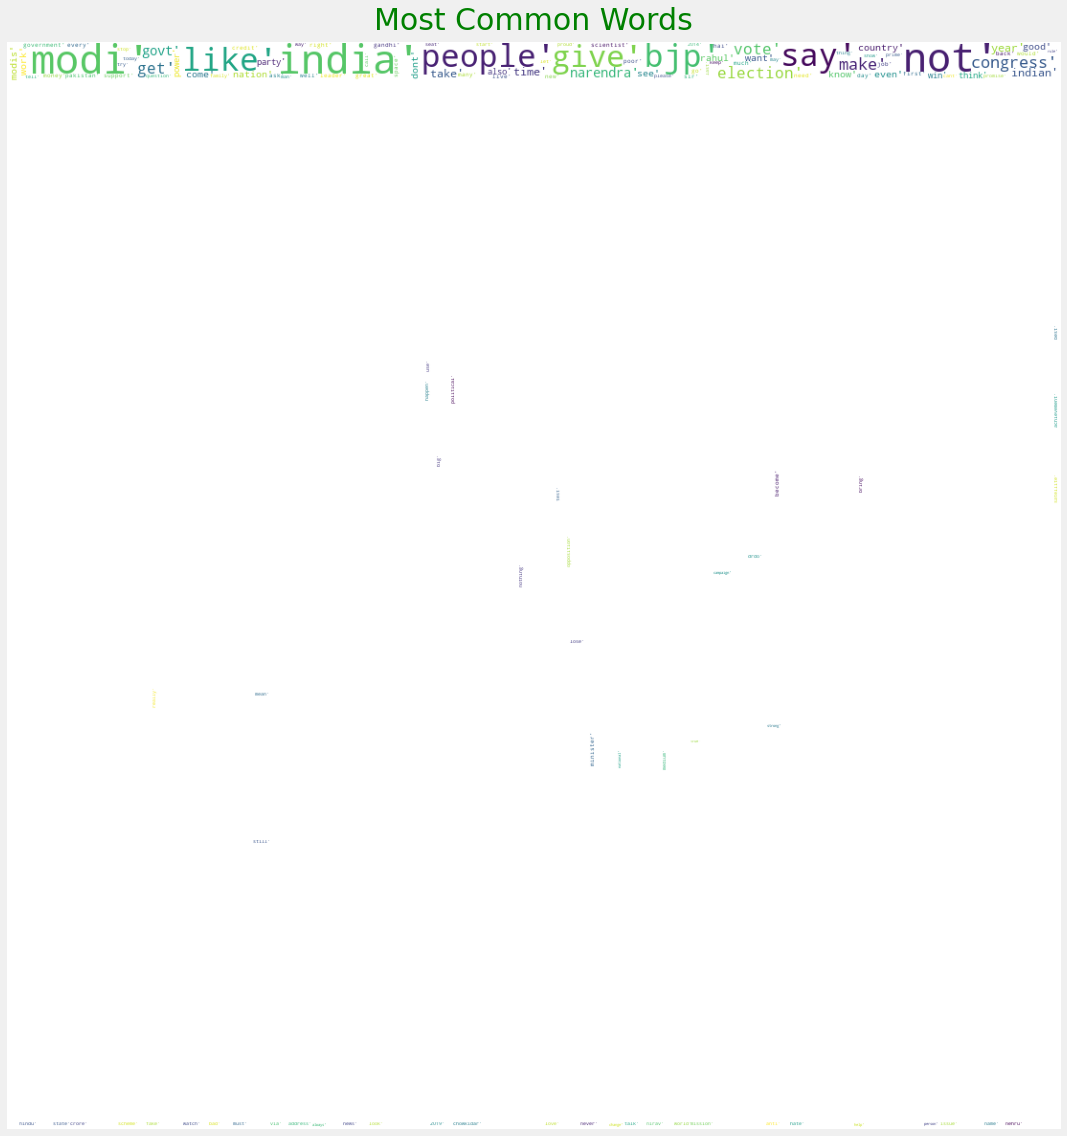

In [ ]:
comments_mask = np.array(Image.open('wordcloud.png'))
plot_wordcloud(df['lemmatized'], comments_mask,
               'Most Common Words',
               title_size=30)

In [ ]:
%%time
documents = [text.split() for text in df_train.lemma_str] 

CPU times: user 187 ms, sys: 68.7 ms, total: 256 ms
Wall time: 268 ms


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 8353


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 3min 23s, sys: 1.13 s, total: 3min 24s
Wall time: 1min 50s


(37098206, 45364480)

In [ ]:
w2v_model.wv.most_similar("bjp")

[('party', 0.459343284368515),
 ('trs', 0.44658613204956055),
 ('cadre', 0.411460280418396),
 ('ncp', 0.4058728516101837),
 ('coalition', 0.39137908816337585),
 ('jds', 0.38767507672309875),
 ('congress', 0.3792244791984558),
 ('karnataka', 0.37780892848968506),
 ('ally', 0.3709278404712677),
 ('dmk', 0.3684611916542053)]

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.lemma_str)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 70297
CPU times: user 2.87 s, sys: 44.6 ms, total: 2.91 s
Wall time: 3.23 s


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.lemma_str), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.lemma_str), maxlen=SEQUENCE_LENGTH)

CPU times: user 2.39 s, sys: 98.9 ms, total: 2.49 s
Wall time: 2.47 s


In [ ]:
labels = df_train.category.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.category.tolist())

y_train = encoder.transform(df_train.category.tolist())
y_test = encoder.transform(df_test.category.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (86206, 1)
y_test (21552, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (86206, 300)
y_train (86206, 1)

x_test (21552, 300)
y_test (21552, 1)


In [ ]:
y_train[:10]

array([[1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1]])

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(70297, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.6))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          21089100  
                                                                 
 dropout_1 (Dropout)         (None, 300, 300)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 21,249,601
Trainable params: 160,501
Non-trainable params: 21,089,100
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=1, #EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

76/76 [==============================] - ETA: 0s - loss: 0.6022 - accuracy: 0.6685 

76/76 [==============================] - 1056s 14s/step - loss: 0.6022 - accuracy: 0.6685 - val_loss: 0.5331 - val_accuracy: 0.7338 - lr: 0.0010
CPU times: user 31min 17s, sys: 2min 10s, total: 33min 27s
Wall time: 18min 28s


In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

22/22 [==============================] - 59s 3s/step - loss: 0.5417 - accuracy: 0.7312

ACCURACY: 0.7311618328094482
LOSS: 0.5417197942733765
CPU times: user 1min 45s, sys: 7.01 s, total: 1min 52s
Wall time: 1min 21s


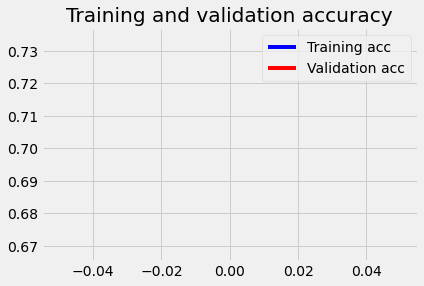

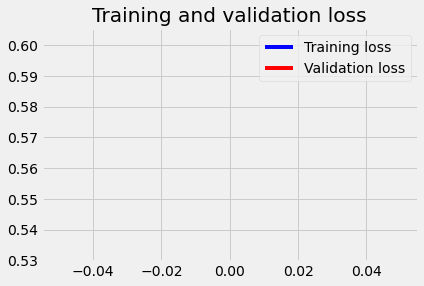

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL ### Whatever not coming in negative and positive sentiments has been considered as neutral
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(clean_text, include_neutral=True):
    start_at = time.time()
    # Tokenize clean_text
    x_test = pad_sequences(tokenizer.texts_to_sequences([clean_text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [ ]:
predict("I love the music")

1/1 [==============================] - 1s 698ms/step


{'label': 'POSITIVE',
 'score': 0.9559671878814697,
 'elapsed_time': 0.7618246078491211}

In [ ]:
predict("I do not know him")

1/1 [==============================] - 0s 153ms/step


{'label': 'POSITIVE',
 'score': 0.7700412273406982,
 'elapsed_time': 0.26239466667175293}

In [ ]:
predict("I have nothing to lose")

1/1 [==============================] - 0s 194ms/step


{'label': 'POSITIVE',
 'score': 0.7180179357528687,
 'elapsed_time': 0.27672886848449707}

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.category)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

3/3 [==============================] - 66s 19s/step
CPU times: user 1min 40s, sys: 19.5 s, total: 2min
Wall time: 1min 22s


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

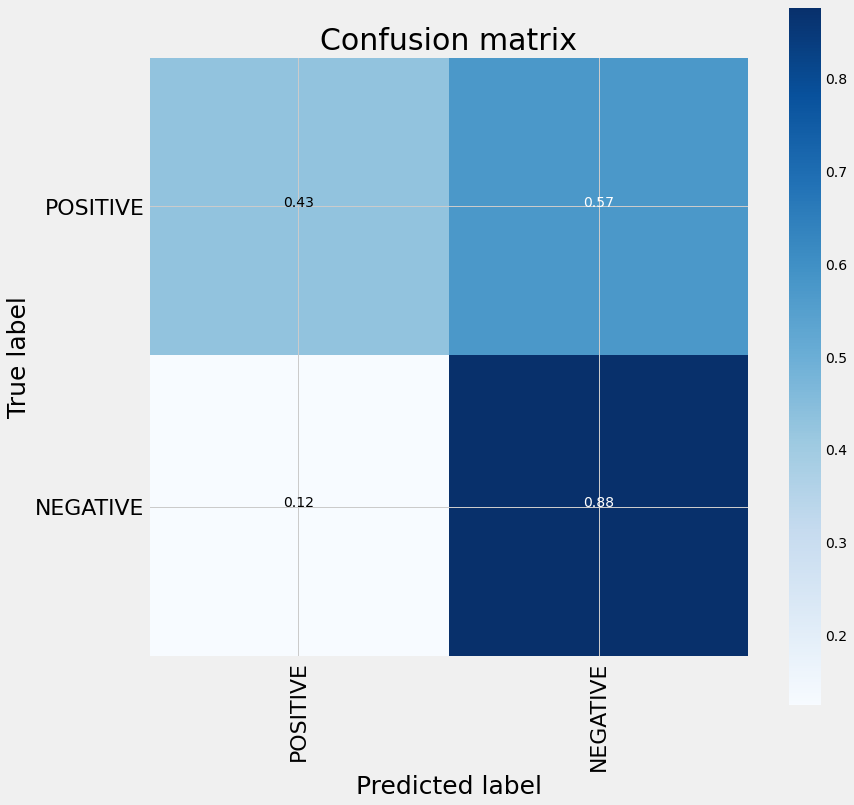

CPU times: user 554 ms, sys: 26.5 ms, total: 580 ms
Wall time: 753 ms


In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.category.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.63      0.43      0.51      7026
    POSITIVE       0.76      0.88      0.81     14526

    accuracy                           0.73     21552
   macro avg       0.69      0.65      0.66     21552
weighted avg       0.72      0.73      0.72     21552



In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

0.7311618411284335

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)